Original screams: 80 Augmented screams: 160


[I 2025-09-08 17:47:14,063] A new study created in memory with name: no-name-890cefe2-11f7-43de-9f0a-1687ab42bc51


Dataset shape: (440, 40) (440,)
Screams: 240 Non-screams: 200


C:\Users\rutuj\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:47:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\rutuj\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:47:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\rutuj\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:47:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\rutuj\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:47:14] WARNING: C:\actio


Best Parameters: {'max_depth': 5, 'learning_rate': 0.013530130283711236, 'n_estimators': 394, 'subsample': 0.5273763562134586, 'colsample_bytree': 0.6576753256425689}


C:\Users\rutuj\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:47:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\rutuj\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:47:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\rutuj\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:47:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\rutuj\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:47:39] WARNING: C:\actio


Optimal Threshold: 0.9994378447532654

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        48

    accuracy                           1.00        88
   macro avg       1.00      1.00      1.00        88
weighted avg       1.00      1.00      1.00        88

Confusion Matrix:
 [[40  0]
 [ 0 48]]


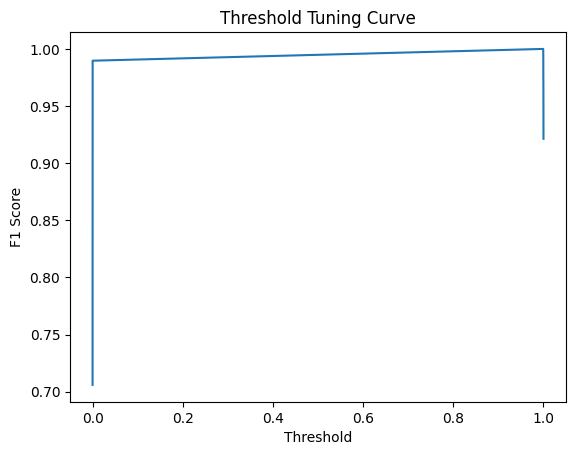

In [2]:
# ==============================================
# Human Scream Detection System - Synthetic Demo
# ==============================================

# Libraries
import numpy as np
import librosa
import librosa.effects
import librosa.feature
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import precision_recall_curve, f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import optuna
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt

# ==============================================
# STEP 1: Generate Synthetic Dataset
# ==============================================
def generate_synthetic_audio(length=2.0, sr=16000, freq=800, noise_level=0.02):
    """Generate synthetic audio: sine wave + noise"""
    t = np.linspace(0, length, int(sr*length), endpoint=False)
    signal = 0.5*np.sin(2*np.pi*freq*t)  # pure tone
    noise = noise_level*np.random.randn(len(t))  # background noise
    return signal + noise

def extract_mfcc(audio, sr=16000, n_mfcc=40):
    """Extract MFCC features and take mean across time"""
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfcc.mean(axis=1)

# Create scream-like sounds (high freq) and non-screams (low freq)
screams = [generate_synthetic_audio(freq=np.random.randint(600,1200)) for _ in range(80)]
nonscreams = [generate_synthetic_audio(freq=np.random.randint(100,400)) for _ in range(200)]

# ==============================================
# STEP 2: Data Augmentation for Screams
# ==============================================
augmented_screams = []
for s in screams:
    # Pitch shift up or down
    ps = librosa.effects.pitch_shift(s, sr=16000, n_steps=np.random.choice([-2, 2]))
    # Time stretch (slow down or speed up)
    ts = librosa.effects.time_stretch(s, rate=np.random.uniform(0.8, 1.2))
    augmented_screams.extend([ps, ts])

# Add augmented screams to dataset
all_screams = screams + augmented_screams
print("Original screams:", len(screams), "Augmented screams:", len(augmented_screams))

# ==============================================
# STEP 3: Feature Extraction
# ==============================================
X_screams = np.array([extract_mfcc(a) for a in all_screams])
X_nonscreams = np.array([extract_mfcc(a) for a in nonscreams])

X_raw = np.vstack((X_screams, X_nonscreams))
y = np.array([1]*len(X_screams) + [0]*len(X_nonscreams))

print("Dataset shape:", X_raw.shape, y.shape)
print("Screams:", sum(y==1), "Non-screams:", sum(y==0))

# ==============================================
# STEP 4: Feature Scaling
# ==============================================
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

# ==============================================
# STEP 5: Stratified Cross-Validation Setup
# ==============================================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ==============================================
# STEP 6: Hyperparameter Tuning with Bayesian Optimization
# ==============================================
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 400),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "eval_metric": "logloss",
        "use_label_encoder": False,
        "n_jobs": -1,
        "random_state": 42,
    }
    
    model = XGBClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X[train_idx], X[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        scores.append(f1_score(y_valid, preds))
    return np.mean(scores)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)  # keep trials small for demo
best_params = study.best_params
print("\nBest Parameters:", best_params)

# ==============================================
# STEP 7: Train Final Model with Calibrated Probabilities
# ==============================================
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

base_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric="logloss")
calibrated_model = CalibratedClassifierCV(base_model, method='isotonic', cv=5)
calibrated_model.fit(X_train, y_train)

# ==============================================
# STEP 8: Threshold Tuning
# ==============================================
probs = calibrated_model.predict_proba(X_test)[:, 1]
prec, rec, thresh = precision_recall_curve(y_test, probs)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)
best_thresh = thresh[np.argmax(f1_scores)]
print("\nOptimal Threshold:", best_thresh)

# ==============================================
# STEP 9: Evaluation
# ==============================================
final_preds = (probs >= best_thresh).astype(int)

print("\nClassification Report:\n", classification_report(y_test, final_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, final_preds))

plt.plot(thresh, f1_scores[:-1])
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("Threshold Tuning Curve")
plt.show()


In [4]:
# ==========================
# Human Scream Detection (Synthetic Dataset)
# With Bayesian Optimization, Stratified CV, Scaling,
# Data Augmentation, Calibrated Probabilities, Threshold Tuning
# ==========================

# Install dependencies if missing
!pip install xgboost optuna librosa ipywidgets --quiet

import numpy as np
import librosa
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import precision_recall_curve, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
import optuna
import random

# --------------------------
# 1. Synthetic Dataset Generation
# --------------------------
def generate_scream(n_samples=100, duration=1.0, sr=16000):
    """Generate synthetic scream-like signals."""
    screams = []
    for _ in range(n_samples):
        # random high frequency tone + noise
        freq = np.random.uniform(600, 1200)
        t = np.linspace(0, duration, int(sr * duration), endpoint=False)
        signal = 0.5 * np.sin(2 * np.pi * freq * t)
        noise = np.random.normal(0, 0.2, signal.shape)
        scream = signal + noise
        screams.append(scream)
    return screams

def generate_non_scream(n_samples=100, duration=1.0, sr=16000):
    """Generate synthetic non-scream signals (low freq + soft noise)."""
    nonscreams = []
    for _ in range(n_samples):
        freq = np.random.uniform(100, 300)
        t = np.linspace(0, duration, int(sr * duration), endpoint=False)
        signal = 0.3 * np.sin(2 * np.pi * freq * t)
        noise = np.random.normal(0, 0.05, signal.shape)
        nonscream = signal + noise
        nonscreams.append(nonscream)
    return nonscreams

# Generate initial dataset
screams = generate_scream(80)
nonscreams = generate_non_scream(80)

# --------------------------
# 2. Data Augmentation
# --------------------------
def augment_signal(signal, sr=16000):
    """Apply pitch shift and time stretch."""
    if random.random() > 0.5:
        signal = librosa.effects.pitch_shift(signal, sr=sr, n_steps=np.random.uniform(-2, 2))
    if random.random() > 0.5:
        signal = librosa.effects.time_stretch(signal, rate=np.random.uniform(0.8, 1.2))
    return signal

augmented_screams = [augment_signal(sig) for sig in screams]
augmented_nonscreams = [augment_signal(sig) for sig in nonscreams]

screams.extend(augmented_screams)
nonscreams.extend(augmented_nonscreams)

print(f"Original screams: 80 Augmented screams: {len(screams)}")

# --------------------------
# 3. Feature Extraction (MFCC)
# --------------------------
def extract_features(signals, sr=16000, n_mfcc=20):
    feats = []
    for sig in signals:
        mfcc = librosa.feature.mfcc(y=sig, sr=sr, n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)
        feats.append(mfcc_mean)
    return np.array(feats)

X_scream = extract_features(screams)
X_nonscream = extract_features(nonscreams)

X = np.vstack([X_scream, X_nonscream])
y = np.array([1]*len(X_scream) + [0]*len(X_nonscream))

print("Dataset shape:", X.shape, y.shape)
print("Screams:", sum(y==1), "Non-screams:", sum(y==0))

# --------------------------
# 4. Feature Scaling
# --------------------------
scaler = StandardScaler()
X = scaler.fit_transform(X)

# --------------------------
# 5. Bayesian Hyperparameter Optimization
# --------------------------
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 400),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "eval_metric": "logloss",
        "use_label_encoder": False,
        "n_jobs": -1,
        "random_state": 42,
    }
    
    model = XGBClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X[train_idx], X[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        scores.append(f1_score(y_valid, preds))
    return np.mean(scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best Parameters:", study.best_params)

# --------------------------
# 6. Train Final Model with Calibration
# --------------------------
best_params = study.best_params
best_params.update({"eval_metric": "logloss", "use_label_encoder": False, "n_jobs": -1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

base_model = XGBClassifier(**best_params)
calibrated_model = CalibratedClassifierCV(base_model, method="sigmoid", cv=5)
calibrated_model.fit(X_train, y_train)

# --------------------------
# 7. Threshold Tuning
# --------------------------
probs = calibrated_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print("\nOptimal Threshold:", optimal_threshold)

# --------------------------
# 8. Evaluation
# --------------------------
final_preds = (probs >= optimal_threshold).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, final_preds))

print("Confusion Matrix:\n", confusion_matrix(y_test, final_preds))



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Original screams: 80 Augmented screams: 160


[I 2025-09-08 17:53:55,540] A new study created in memory with name: no-name-e7752c8e-28eb-4472-8ec0-f8d41d633173


Dataset shape: (320, 20) (320,)
Screams: 160 Non-screams: 160


C:\Users\rutuj\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:53:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\rutuj\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:53:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\rutuj\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:53:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\rutuj\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:53:56] WARNING: C:\actio

Best Parameters: {'max_depth': 4, 'learning_rate': 0.022004173535948857, 'n_estimators': 251, 'subsample': 0.6410879841525194, 'colsample_bytree': 0.6627886801738533}


C:\Users\rutuj\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:54:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\rutuj\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:54:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\rutuj\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:54:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Optimal Threshold: 0.9125450744257921

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        32

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64

Confusion Matrix:
 [[32  0]
 [ 0 32]]



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Total screams: 160, Total non-screams: 160


[I 2025-09-08 17:55:03,964] A new study created in memory with name: no-name-47a4c035-9625-48ac-baae-aea7935aad39


Dataset shape: (320, 20) (320,)


C:\Users\rutuj\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:55:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\rutuj\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:55:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\rutuj\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:55:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\rutuj\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:55:04] WARNING: C:\actio

Best Parameters: {'max_depth': 9, 'learning_rate': 0.06563110235110695, 'n_estimators': 113, 'subsample': 0.505002853272581, 'colsample_bytree': 0.8105678136519683}


C:\Users\rutuj\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:55:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\rutuj\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:55:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\rutuj\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:55:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Optimal Threshold: 0.9583786765058149

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        32

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64

Confusion Matrix:
 [[32  0]
 [ 0 32]]


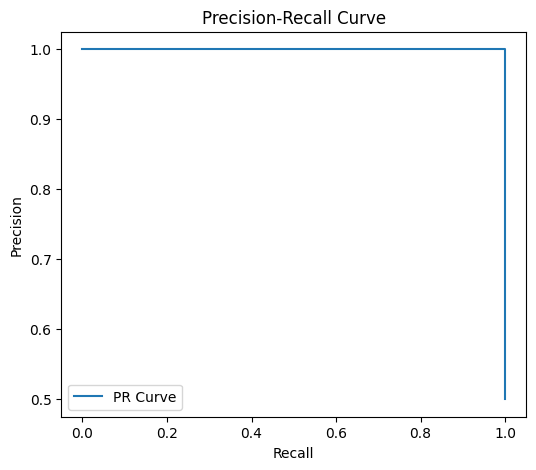

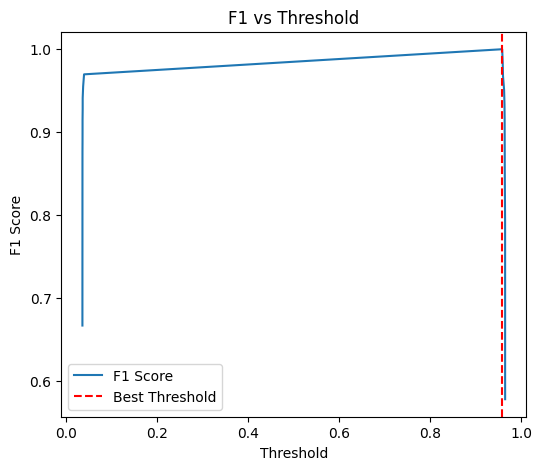

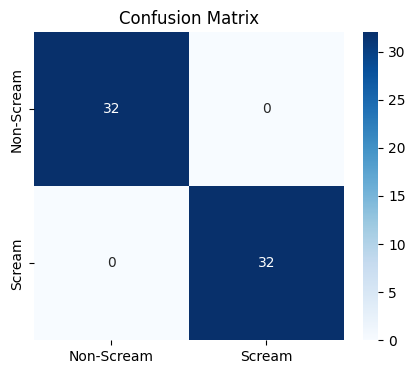

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

In [5]:
# ==========================
# Human Scream Detection (Synthetic Dataset)
# With Bayesian Optimization, Stratified CV, Scaling,
# Data Augmentation, Calibrated Probabilities, Threshold Tuning + Visualizations
# ==========================

# Install dependencies if missing
!pip install xgboost optuna librosa ipywidgets matplotlib seaborn --quiet

import numpy as np
import librosa
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    precision_recall_curve, f1_score, classification_report,
    confusion_matrix
)
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
import optuna
import random
import matplotlib.pyplot as plt
import seaborn as sns
from optuna.visualization import plot_param_importances

# --------------------------
# 1. Synthetic Dataset Generation
# --------------------------
def generate_scream(n_samples=100, duration=1.0, sr=16000):
    screams = []
    for _ in range(n_samples):
        freq = np.random.uniform(600, 1200)
        t = np.linspace(0, duration, int(sr * duration), endpoint=False)
        signal = 0.5 * np.sin(2 * np.pi * freq * t)
        noise = np.random.normal(0, 0.2, signal.shape)
        scream = signal + noise
        screams.append(scream)
    return screams

def generate_non_scream(n_samples=100, duration=1.0, sr=16000):
    nonscreams = []
    for _ in range(n_samples):
        freq = np.random.uniform(100, 300)
        t = np.linspace(0, duration, int(sr * duration), endpoint=False)
        signal = 0.3 * np.sin(2 * np.pi * freq * t)
        noise = np.random.normal(0, 0.05, signal.shape)
        nonscream = signal + noise
        nonscreams.append(nonscream)
    return nonscreams

screams = generate_scream(80)
nonscreams = generate_non_scream(80)

# --------------------------
# 2. Data Augmentation
# --------------------------
def augment_signal(signal, sr=16000):
    if random.random() > 0.5:
        signal = librosa.effects.pitch_shift(signal, sr=sr, n_steps=np.random.uniform(-2, 2))
    if random.random() > 0.5:
        signal = librosa.effects.time_stretch(signal, rate=np.random.uniform(0.8, 1.2))
    return signal

screams += [augment_signal(sig) for sig in screams]
nonscreams += [augment_signal(sig) for sig in nonscreams]

print(f"Total screams: {len(screams)}, Total non-screams: {len(nonscreams)}")

# --------------------------
# 3. Feature Extraction (MFCC)
# --------------------------
def extract_features(signals, sr=16000, n_mfcc=20):
    feats = []
    for sig in signals:
        mfcc = librosa.feature.mfcc(y=sig, sr=sr, n_mfcc=n_mfcc)
        feats.append(np.mean(mfcc, axis=1))
    return np.array(feats)

X_scream = extract_features(screams)
X_nonscream = extract_features(nonscreams)

X = np.vstack([X_scream, X_nonscream])
y = np.array([1]*len(X_scream) + [0]*len(X_nonscream))

print("Dataset shape:", X.shape, y.shape)

# --------------------------
# 4. Feature Scaling
# --------------------------
scaler = StandardScaler()
X = scaler.fit_transform(X)

# --------------------------
# 5. Bayesian Hyperparameter Optimization
# --------------------------
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 400),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "eval_metric": "logloss",
        "use_label_encoder": False,
        "n_jobs": -1,
        "random_state": 42,
    }
    model = XGBClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X[train_idx], X[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        scores.append(f1_score(y_valid, preds))
    return np.mean(scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best Parameters:", study.best_params)

# --------------------------
# 6. Train Final Model with Calibration
# --------------------------
best_params = study.best_params
best_params.update({"eval_metric": "logloss", "use_label_encoder": False, "n_jobs": -1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

base_model = XGBClassifier(**best_params)
calibrated_model = CalibratedClassifierCV(base_model, method="sigmoid", cv=5)
calibrated_model.fit(X_train, y_train)

# --------------------------
# 7. Threshold Tuning
# --------------------------
probs = calibrated_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
best_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[best_idx]

print("\nOptimal Threshold:", optimal_threshold)

# --------------------------
# 8. Evaluation
# --------------------------
final_preds = (probs >= optimal_threshold).astype(int)

print("\nClassification Report:\n", classification_report(y_test, final_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, final_preds))

# --------------------------
# 9. Visualizations
# --------------------------

# Precision-Recall Curve
plt.figure(figsize=(6,5))
plt.plot(recalls, precisions, label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# F1 vs Threshold Curve
plt.figure(figsize=(6,5))
plt.plot(thresholds, f1_scores[:-1], label="F1 Score")
plt.axvline(optimal_threshold, color="red", linestyle="--", label="Best Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 vs Threshold")
plt.legend()
plt.show()

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Scream","Scream"], yticklabels=["Non-Scream","Scream"])
plt.title("Confusion Matrix")
plt.show()

# Optuna Hyperparameter Importance
fig = plot_param_importances(study)
fig.show()
